<a href="https://colab.research.google.com/github/tnwls6865/cau_mAI_tutorial/blob/main/Week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Nearest Neighbor Classifier.

새로운 데이터를 입력 받았을 때 학습 데이터에서 가장 가까이 있는 것이 무엇이냐를 중심으로 새로운 데이터의 label을 정해주는 알고리즘 

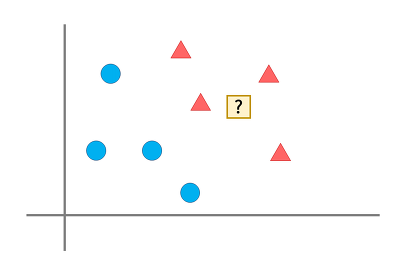

###k-Nearest Neighbor
학습 데이터에서 가장 가까운 단일 데이터를 보는 것 대신 가장 가까운 상위 K개의 데이터를 보고 새로운 데이터의 label을 설정해주는 알고리즘 \\
K는 hyperparameter \\ 

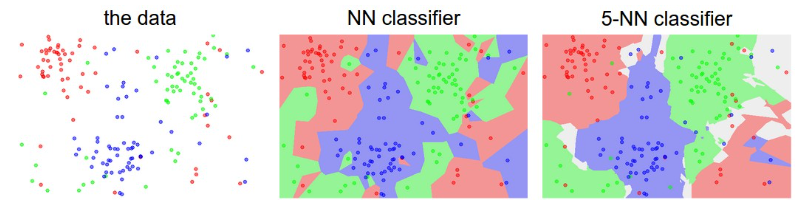 \\
The kNN classifier consists of two stages:

* During training, the classifier takes the training data and simply remembers it
* During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
* The value of k is cross-validated


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/CAU_mAI/

/content/drive/MyDrive/CAU_mAI


In [ ]:
!git clone https://github.com/tnwls6865/cau_mAI_tutorial.git

Cloning into 'cau_mAI_tutorial'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 

--2022-12-30 04:53:16--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  53.0MB/s    in 3.1s    

2022-12-30 04:53:19 (53.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10

# 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules automatically if it is changed;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
(X_train, y_train) , (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [3]:
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


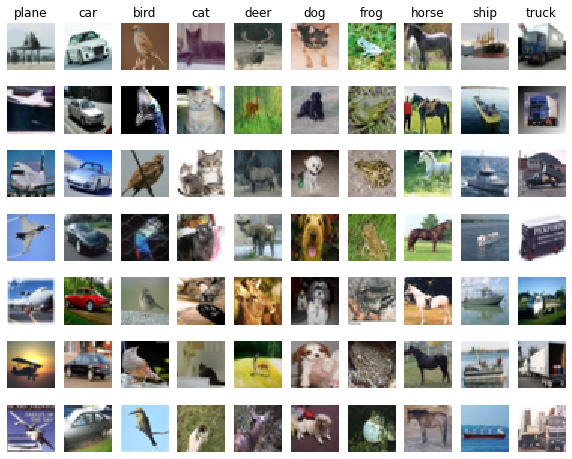

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)  # return idx of y_train that has value y
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# 효율성을 위한 데이터 샘플링
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# image data를 행으로 재구성
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### L2 Distance
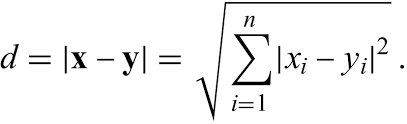

### KNN claasifier with L2 distance

In [ ]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    k-최근접 이웃의 경우 훈련 데이터를 기억하는 것

    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    테스트 데이터의 레이블을 예측


    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    X의 각 테스트 포인트와 각 트레이닝 포인트 사이의 거리를 계산

    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        # L2 distance
        dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :]) **2))

    return dists

  def compute_distances_one_loop(self, X):
    """
    X의 각 테스트 포인트와 각 트레이닝 포인트 사이의 거리를 계산

    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
    
      dists[i, :] = np.sqrt(np.sum((self.X_train - X[i, :])**2, axis=1))

    return dists

  def compute_distances_no_loops(self, X):
    """
    X의 각 테스트 포인트와 각 트레이닝 포인트 사이의 거리를 계산

    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    
    dists = np.sqrt((-2 * np.dot(X, self.X_train.T)) + np.sum(X**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1))

    return dists

  def predict_labels(self, dists, k=1):
    """
    각 테스트 포인트에 대한 레이블을 예측

    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # k개의 가장 가까운 이웃의 레이블을 저장
      closest_y = []        
      k_nearest_idxs = np.argsort(dists[i, :])[:k]
      closest_y = self.y_train[k_nearest_idxs].flatten()
      
      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [ ]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


In [ ]:
# k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test.flatten())
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 88 / 500 correct => accuracy: 0.176000


In [ ]:
# k = 5
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test.flatten())
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 100 / 500 correct => accuracy: 0.200000


### SVM loss 
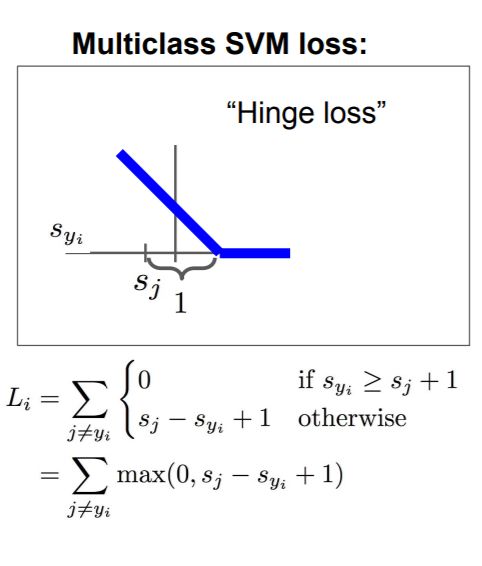

### Multiclass Support Vector Machine exercise

In [4]:
(X_train, y_train) , (X_test, y_test) = cifar10.load_data()

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# validation set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# training set
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# test set
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [5]:
# 전처리 : 이미지 데이터를 행으로 재구성 
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130 135 132 130 135 131 130 136 132 131]


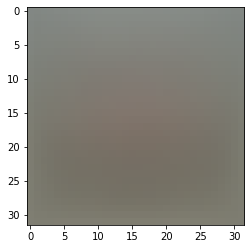

In [6]:
# 전처리 : 평균 이미지 빼기
# 학습 데이터를 기반으로 평균이미지 계산
mean_image = np.mean(X_train, axis=0).astype('uint8')
show_mean_img = mean_image.reshape((32,32,3)).copy()
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(show_mean_img.astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# train set과 test set에 대해 평균 빼기 
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# bias dimension 추가 해주기 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
def svm_loss_naive(W, X, y, reg):
 
  dW = np.zeros(W.shape) # gradient 를 0으로 초기화

  # loss와 gradient 계산
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  
  for i in range(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        dW[:, j] += X[i]  # this is only added
        y = y.flatten()
        dW[:, y[i]] -= X[i]

  # 평균 loss 
  loss /= num_train
  dW /= num_train
    
  # regularization 추가
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg * W

  return loss, dW


def svm_loss_vectorized(W, X, y, reg):

  C = W.shape[1]
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros(W.shape) # gradient 를 0으로 초기화

  scores = np.dot(X, W)    # (N, C)
  correct_scores = scores[np.arange(N), y]  # (N, )
  margins = np.maximum(scores - correct_scores.reshape(N, 1) + 1.0, 0)  # (N, C)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  loss += 0.5 * reg * np.sum(W * W)
  
  dscores = np.zeros_like(scores)  # (N, C)
  dscores[margins > 0] = 1  
  dscores[np.arange(N), y] -= np.sum(dscores, axis=1)   #  (N, 1) = (N, 1)

  dW = np.dot(X.T, dscores) 
  dW /= N
  dW += reg * W 

  return loss, dW


In [10]:
# random SVM weight matrix 만들기
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))

loss: 10.973223


In [12]:
# random SVM weight matrix 만들기
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_vectorized(W, X_dev, y_dev.flatten(), 0.00001)
print('loss: %f' % (loss, ))

loss: 11.435360


### Softmax Classifier

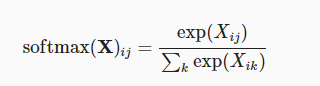

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  
  (X_train, y_train) , (X_test, y_test) = cifar10.load_data()
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis=0).astype('uint8')
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3073)
Test labels shape:  (1000, 1)
dev data shape:  (500, 3073)
dev labels shape:  (500, 1)


In [ ]:
def softmax_loss_naive(W, X, y, reg):

  # loss와 gradient를 zero로 초기화.
  N, D = X.shape
  C = W.shape[1]

  loss = 0.0
  out = np.zeros((N,C))
  dW = np.zeros_like(W)  # (3073, 10)

  ########
  ##code##
  ########
  
  # backward
  out[np.arange(N), y] -= 1   # (N, C)
 
  for i in range(N):
    for j in range(D):
      for k in range(C):
        dW[j, k] += X[i, j] * out[i, k] 

  # add reg term
  dW /= N
  dW += reg * W
  
  return loss, dW


In [ ]:
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev.flatten(), 0.0)

print ('loss: %f' % loss )

# sanity check
########
##code##
########

loss: 2.680710
sanity check: 2.302585


### TODO : Linear classifier 

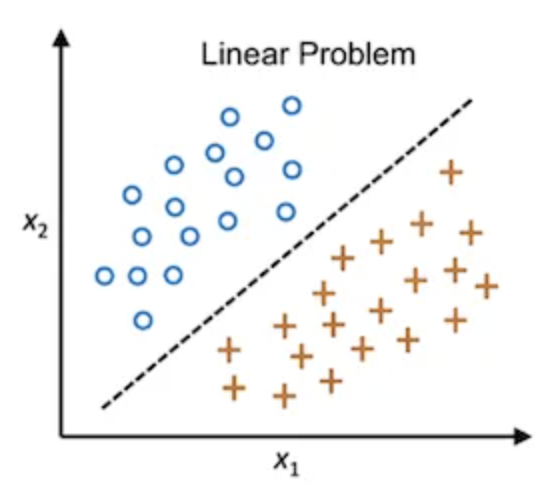

In [ ]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Inputs:
    - X: array (N, D) training data; N : 샘플 갯수 D 차원 
    - y: array (N,) training labels; y[i] = c : 0 <= c < C for C classes
    - learning_rate: (float)
    - reg: (float) regularization 강도
    - num_iters: (integer) number of steps 
    - batch_size: (integer) number of training examples 
    - verbose: (boolean) If true, print progress

    Outputs: 각 training iteration에서 loss function value를 포함하고 있는 list
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # y는 0...K-1 를 갖는다고 가정 (K는 classes 개수)
    if self.W is None:
      # 초기화 
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # gradinet detctiont W
    loss_history = []
    for it in xrange(num_iters):
      X_batch = None
      y_batch = None

      # batch size로 샘플링
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]
        

      ########
      ##code##
      # loss와 gradient계산하기 #
      ########
      
      
      loss_history.append(loss)

      ########
      ##code##
      # gradient와 learning rate를 활용하여 weight update #
      ########

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):

    y_pred = np.zeros(X.shape[1])
    ########
    ##code##
    # prediction(y_pred)에서 가장 높은 값을 추출#
    ########
    
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    pass